<a href="https://colab.research.google.com/github/areegtarek/ContractNLI-using-BERT/blob/main/ContractNLI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ContractNLI**
**A Dataset for Document-level Natural Language Inference for Contracts**

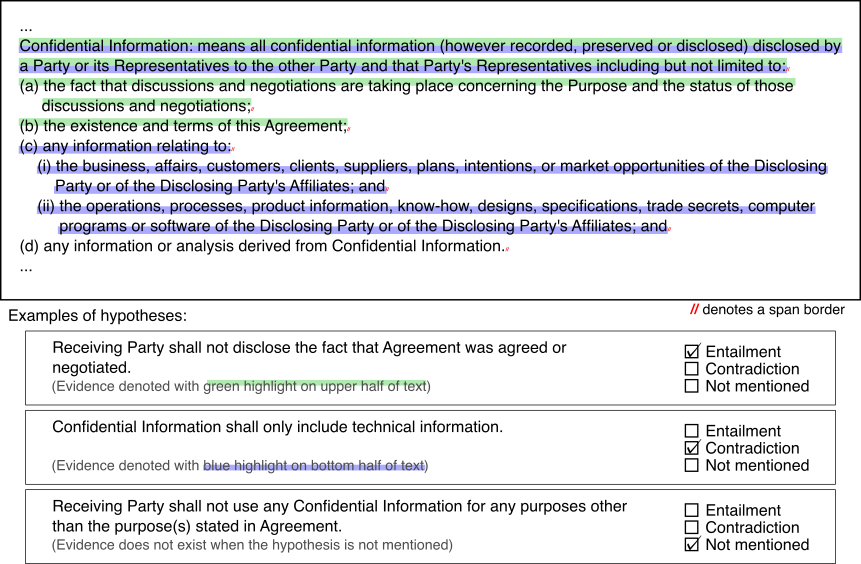

ContractNLI is a dataset for document-level natural language inference (NLI) on contracts whose goal is to automate/support a time-consuming procedure of contract review. In this task, a system is given a set of hypotheses (such as “Some obligations of Agreement may survive termination.”) and a contract, and it is asked to classify whether each hypothesis is entailed by, contradicting to or not mentioned by (neutral to) the contract as well as identifying evidence for the decision as spans in the contract.

# **Dataset specification**
More formally, the task consists of:

Natural language inference (NLI): Document-level three-class classification (one of Entailment, Contradiction or NotMentioned).
Evidence identification: Multi-label binary classification over span_s, where a _span is a sentence or a list item within a sentence. This is only defined when NLI label is either Entailment or Contradiction. Evidence spans need not be contiguous but need to be comprehensively identified where they are redundant.
We have 17 hypotheses annotated on 607 non-disclosure agreements (NDAs). The hypotheses are fixed throughout all the contracts including the test dataset.

Our dataset is provided as JSON files.

    {
      "documents": [
        {
          "id": 1,
          "file_name": "example.pdf",
          "text": "NON-DISCLOSURE AGREEMENT\nThis NON-DISCLOSURE AGREEMENT (\"Agreement\") is entered into this ...",
          "document_type": "search-pdf",
          "url": "https://examplecontract.com/example.pdf",
          "spans": [
            [0, 24],
            [25, 89],
            ...
          ],
          "annotation_sets": [
            {
              "annotations": {
                "nda-1": {
                  "choice": "Entailment",
                  "spans": [
                    12,
                    13,
                    91
                  ]
                },
                "nda-2": {
                  "choice": "NotMentioned",
                  "spans": []
                },
                ...
              }
            }
          ]
        },
        ...
      ],
      "labels": {
        "nda-1": {
          "short_description": "Explicit identification",
          "hypothesis": "All Confidential Information shall be expressly identified by the Disclosing Party."
        },
        ...
      }
    }

In [ ]:
#reading/writing JSON
import json
#plotting
import matplotlib.pyplot as plt
#calculating model metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
#calculating precision and recall
from sklearn.metrics import precision_score, recall_score,f1_score,confusion_matrix
#computing class weights
from sklearn.utils import compute_class_weight
#Generic Transformer model
from transformers import AutoModel
#Transformer model for classification tasks
from transformers import AutoModelForSequenceClassification
#Generic tokenizer
from transformers import AutoTokenizer
#Bert model for classification
from transformers import BertForSequenceClassification
#Bert tokenizer
from transformers import BertTokenizer
#Deberta model for classification
from transformers import DebertaForSequenceClassification
#Deberta tokenizer
from transformers import DebertaTokenizer
#reading CSV files
import csv
#network analysis
import networkx as nx
#arrays and math
import numpy as np
#dataframes
import pandas as pd
#PyTorch
import torch
#counting elements
from collections import Counter
#ordered dictionaries
from collections import OrderedDict
#generating word clouds
from wordcloud import WordCloud
#training
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

The raw dataset consists of JSON files containing documents, annotations, and labels. We need to parse this JSON into a CSV format with columns for doc_id, text, hypothesis and label.

The parse_file() function does the following:

- Loads the JSON file

- Extracts the documents, labels and annotation_sets

- Loops through each document and its annotations

- Gets the corresponding hypothesis from the labels

- Appends a row to the output DataFrame with:

    - doc_id
    - text
    - hypothesis
    - label
    - spans


- Returns the resulting DataFrame

We then call this function on the train, dev and test JSON files, and save the output DataFrames to CSV files:

In [ ]:
'''def parse_file(file_name):
    with open(file_name) as f:
        data = json.load(f)

    documents = data['documents']
    labels = data['labels']

    rows = []
    for doc in documents:
        doc_id = doc['id']
        text = doc['text']
        for annotation_key in doc['annotation_sets'][0]['annotations']:
            hyp_key = annotation_key
            label = doc['annotation_sets'][0]['annotations'][hyp_key]['choice']
            spans = doc['annotation_sets'][0]['annotations'][hyp_key]['spans']
            hyp = labels[hyp_key]['hypothesis']
            rows.append([doc_id, text, hyp, label, spans])

    df = pd.DataFrame(rows, columns=['doc_id', 'text', 'hypothesis', 'label', 'spans'])
    return df

train_df = parse_file('/kaggle/input/contractnli/train.json')
train_df.to_csv('contract-nli/train.csv', index=False)

dev_df = parse_file('/kaggle/input/contractnli/dev.json')
dev_df.to_csv('contract-nli/dev.csv', index=False)

test_df = parse_file('/kaggle/input/contractnli/test.json)
test_df.to_csv('contract-nli/test.csv', index=False)'''

"def parse_file(file_name):\n    with open(file_name) as f:\n        data = json.load(f)\n        \n    documents = data['documents'] \n    labels = data['labels']\n    \n    rows = []\n    for doc in documents:\n        doc_id = doc['id'] \n        text = doc['text']\n        for annotation_key in doc['annotation_sets'][0]['annotations']:  \n            hyp_key = annotation_key    \n            label = doc['annotation_sets'][0]['annotations'][hyp_key]['choice']   \n            spans = doc['annotation_sets'][0]['annotations'][hyp_key]['spans'] \n            hyp = labels[hyp_key]['hypothesis'] \n            rows.append([doc_id, text, hyp, label, spans])\n            \n    df = pd.DataFrame(rows, columns=['doc_id', 'text', 'hypothesis', 'label', 'spans'])\n    return df\n\ntrain_df = parse_file('/kaggle/input/contractnli/train.json')  \ntrain_df.to_csv('contract-nli/train.csv', index=False)\n\ndev_df = parse_file('/kaggle/input/contractnli/dev.json')\ndev_df.to_csv('contract-nli/dev.csv'

In [ ]:
# Read CSV using pandas
train = pd.read_csv('/kaggle/input/contractnli/train.csv')
dev = pd.read_csv('/kaggle/input/contractnli/dev.csv')
test = pd.read_csv('/kaggle/input/contractnli/test.csv')

In [ ]:
train.head()

,doc_id,text,hypothesis,label,spans
0,34,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not reverse engineer any...,NotMentioned,[]
1,34,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall destroy or return some C...,Entailment,"[39, 40]"
2,34,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Agreement shall not grant Receiving Party any ...,Entailment,[38]
3,34,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not disclose the fact th...,Entailment,[51]
4,34,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Confidential Information shall only include te...,NotMentioned,[]


In [ ]:
dev.head()

,doc_id,text,hypothesis,label,spans
0,3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not reverse engineer any...,Entailment,"[33, 39]"
1,3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall destroy or return some C...,Entailment,[47]
2,3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Agreement shall not grant Receiving Party any ...,Entailment,[51]
3,3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not disclose the fact th...,Entailment,"[89, 90]"
4,3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Confidential Information shall only include te...,Contradiction,[17]


In [ ]:
test.head()

,doc_id,text,hypothesis,label,spans
0,1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned,[]
1,1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,"[84, 85, 86]"
2,1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment,[45]
3,1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned,[]
4,1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction,"[25, 32]"


In [ ]:
train.info()
dev.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7191 entries, 0 to 7190
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   doc_id      7191 non-null   int64 
 1   text        7191 non-null   object
 2   hypothesis  7191 non-null   object
 3   label       7191 non-null   object
 4   spans       7191 non-null   object
dtypes: int64(1), object(4)
memory usage: 281.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037 entries, 0 to 1036
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   doc_id      1037 non-null   int64 
 1   text        1037 non-null   object
 2   hypothesis  1037 non-null   object
 3   label       1037 non-null   object
 4   spans       1037 non-null   object
dtypes: int64(1), object(4)
memory usage: 40.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2091 entries, 0 to 2090
Data columns (total 5 columns):
 #   Column      No

# **EDA**

**Wordcloud**
Generates a word cloud from the most frequent words in the text. Gives a quick visual of the main topics.

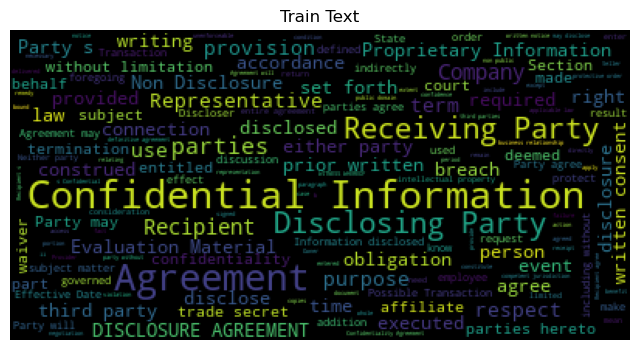

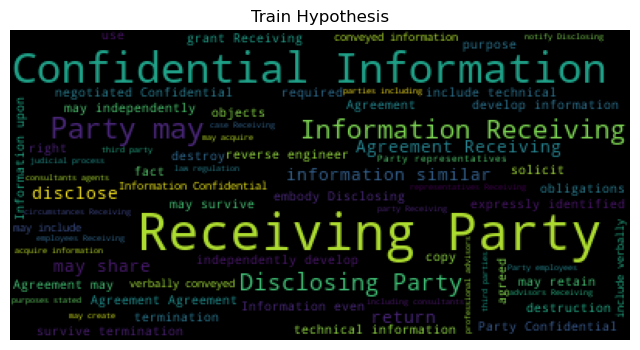

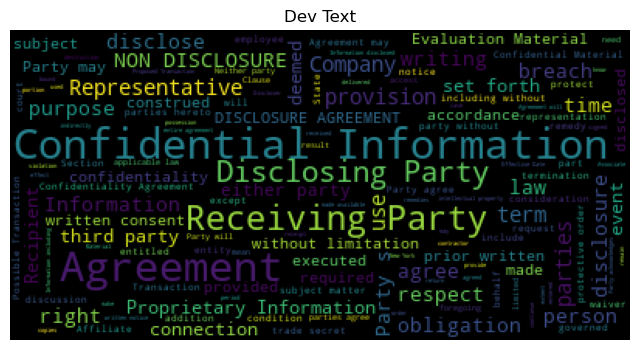

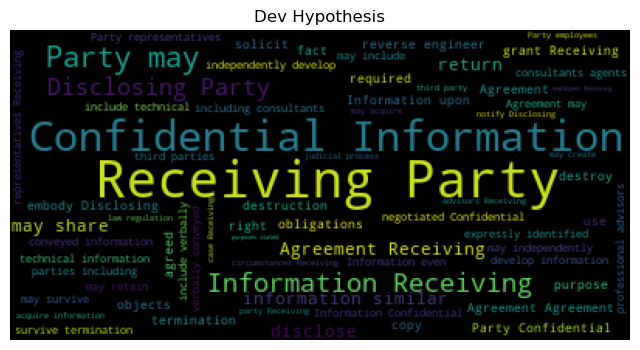

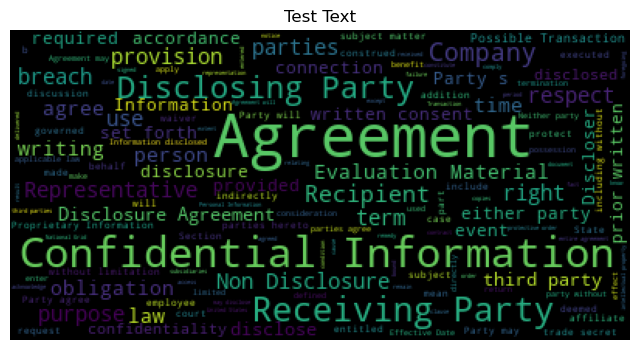

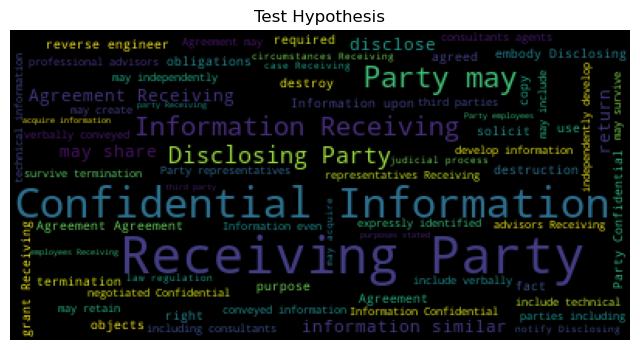

In [ ]:
def plot_word_cloud(text, title):
    wordcloud = WordCloud().generate(text)
    plt.figure(figsize=(8,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)

# Train
plot_word_cloud(" ".join(train.text.tolist()), "Train Text")
plt.show()
plot_word_cloud(" ".join(train.hypothesis.tolist()), "Train Hypothesis")
plt.show()

# Dev
plot_word_cloud(" ".join(dev.text.tolist()), "Dev Text")
plt.show()
plot_word_cloud(" ".join(dev.hypothesis.tolist()), "Dev Hypothesis")
plt.show()

# Test
plot_word_cloud(" ".join(test.text.tolist()), "Test Text")
plt.show()
plot_word_cloud(" ".join(test.hypothesis.tolist()), "Test Hypothesis")
plt.show()

**Bar plot of frequency** Plots the frequency of the top N words as a bar chart. Shows which words are most common.

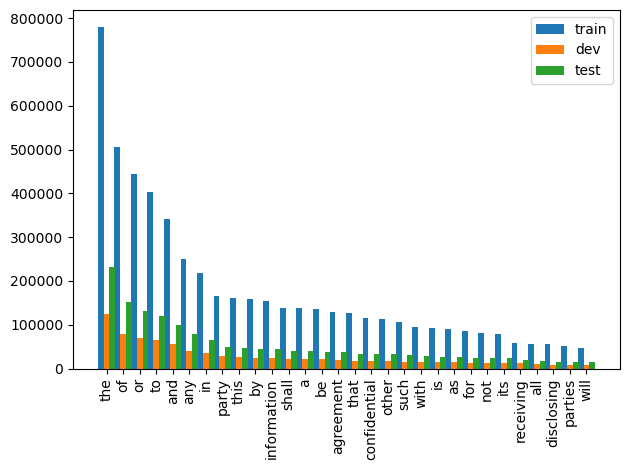

In [ ]:
df = [train, dev, test]
cols = ['text', 'hypothesis']
names = ['train', 'dev', 'test']

# Plot text
indexes = np.arange(30)
bar_width = 0.35

fig, ax = plt.subplots()

for i, d in enumerate(df):
    freq_text = Counter(" ".join(d['text']).lower().split()).most_common(30)
    labels = [t[0] for t in freq_text]
    values = [t[1] for t in freq_text]
    labels = labels[:30]
    values = values[:30]
    ax.bar(indexes + bar_width*i, values, bar_width, label=names[i])

ax.set_xticks(indexes + bar_width)
ax.set_xticklabels(labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

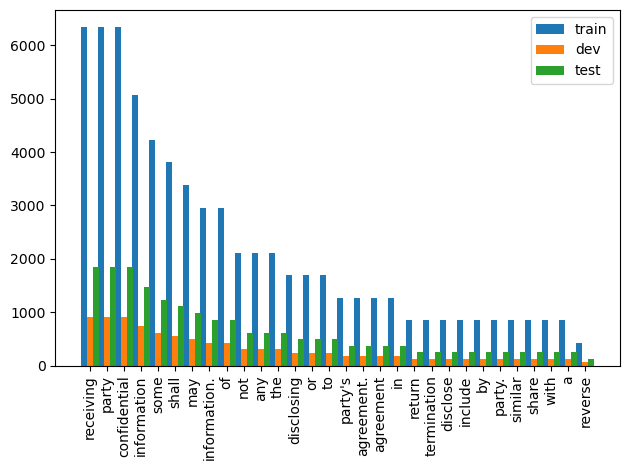

In [ ]:
# Plot hypothesis
indexes = np.arange(30)
fig, ax = plt.subplots()

for i, d in enumerate(df):
    freq_hyp = Counter(" ".join(d['hypothesis']).lower().split()).most_common(30)
    labels = [t[0] for t in freq_hyp]
    values = [t[1] for t in freq_hyp]
    labels = labels[:30]
    values = values[:30]
    ax.bar(indexes + bar_width*i, values, bar_width, label=names[i])

ax.set_xticks(indexes + bar_width)
ax.set_xticklabels(labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

the text column contains more common function words like 'the', 'of', 'and', while the hypothesis column contains more domain-specific words like 'receiving', 'agreement', and 'information.'.

**Check the overall class distribution and label entropy to assess any imbalance.**

In [ ]:
labels_train = train['label'].value_counts()
labels_train

Entailment       3530
NotMentioned     2820
Contradiction     841
Name: label, dtype: int64

In [ ]:
# Train set
counts_train = train['label'].value_counts()
entropy_train = compute_class_weight('balanced',
                                    classes=counts_train.index,
                                    y=train['label'])

print('Train set:')
print(f'Distribution: {counts_train}')
print(f'Entropy: {entropy_train}')

# Dev set
counts_dev = dev['label'].value_counts()
entropy_dev = compute_class_weight('balanced',
                                   classes=counts_dev.index,
                                   y=dev['label'])

print('Dev set:')
print(f'Distribution: {counts_dev}')
print(f'Entropy: {entropy_dev}')

# Test set
counts_test = test['label'].value_counts()
entropy_test = compute_class_weight('balanced',
                                    classes=counts_test.index,
                                    y=test['label'])

print('Test set:')
print(f'Distribution: {counts_test}')
print(f'Entropy: {entropy_test}')

Train set:
Distribution: Entailment       3530
NotMentioned     2820
Contradiction     841
Name: label, dtype: int64
Entropy: [0.67903683 0.85       2.85017836]
Dev set:
Distribution: Entailment       519
NotMentioned     423
Contradiction     95
Name: label, dtype: int64
Entropy: [0.66602441 0.81717888 3.63859649]
Test set:
Distribution: Entailment       968
NotMentioned     903
Contradiction    220
Name: label, dtype: int64
Entropy: [0.72004132 0.77187154 3.16818182]


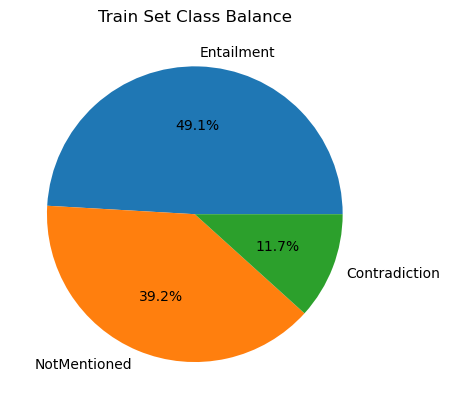

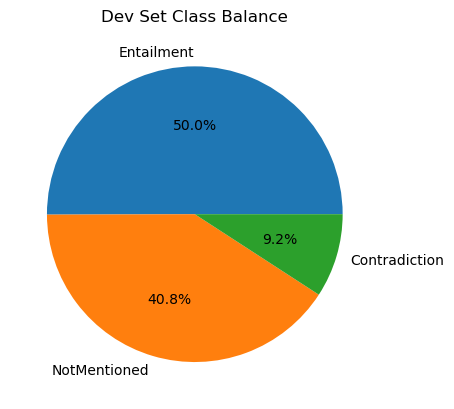

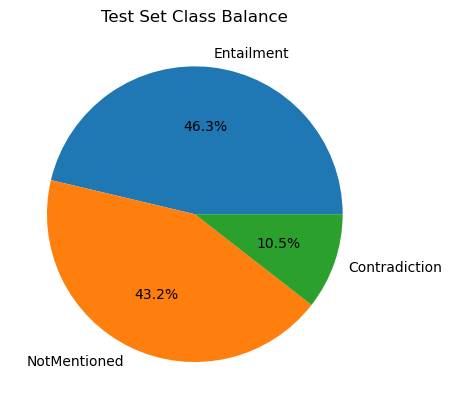

In [ ]:
# Train set
labels_train = train['label'].value_counts()
entailment_train = labels_train['Entailment']
contradiction_train = labels_train['Contradiction']
NotMentioned_train = labels_train['NotMentioned']

# Dev set
labels_dev = dev['label'].value_counts()
entailment_dev = labels_dev['Entailment']
contradiction_dev = labels_dev['Contradiction']
NotMentioned_dev = labels_dev['NotMentioned']

# Test set
labels_test = test['label'].value_counts()
entailment_test = labels_test['Entailment']
contradiction_test = labels_test['Contradiction']
NotMentioned_test = labels_test['NotMentioned']

# Pie chart for train set
plt.pie([entailment_train, NotMentioned_train, contradiction_train], labels=['Entailment', 'NotMentioned', 'Contradiction'],
   autopct = '%1.1f%%')
plt.title("Train Set Class Balance")
plt.show()

# Pie chart for dev set
plt.pie([entailment_dev, NotMentioned_dev, contradiction_dev], labels=['Entailment', 'NotMentioned', 'Contradiction'],
   autopct = '%1.1f%%')
plt.title("Dev Set Class Balance")
plt.show()

# Pie chart for test set
plt.pie([entailment_test, NotMentioned_test, contradiction_test], labels=['Entailment', 'NotMentioned', 'Contradiction'],
   autopct = '%1.1f%%')
plt.title("Test Set Class Balance")
plt.show()

- All splits show Entailment as the majority class
- The dev set has the most balanced distribution, while train is the most imbalanced
- The test and dev sets have more similar distributions, which is ideal

**In terms of addressing imbalance:**

- Oversampling the minority classes (Contradiction and NotMentioned) in the train set would likely be helpful
- Monitoring that the entropy weights become more similar after resampling
- Ensuring the dev and test sets remain relatively balanced during training

This data suggests that class imbalance is an issue, particularly in the train set. Addressing this will likely improve model performance, especially for the minority classes.

In [ ]:
label_mapping = {"NotMentioned": 0, "Entailment": 1, "Contradiction": 2}

train_labels = [label_mapping[label] for label in train['label'].tolist()]
valid_labels = [label_mapping[label] for label in dev['label'].tolist()]
test_labels = [label_mapping[label] for label in dev['label'].tolist()]

# **1- DeBERTa**

In [ ]:
model_name = "microsoft/deberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def tokenize_data(data):
    #the text and hypothesis will speperated by [sep] token to differentiate them.
    return tokenizer(text=data['text'].tolist(), text_pair=data['hypothesis'].tolist(), truncation=True, padding="max_length", max_length=512)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    true_labels = p.label_ids

    # Accuracy
    accuracy = (preds == true_labels).mean()

    # Precision
    precision = precision_score(true_labels, preds,average='weighted')

    # Recall
    recall = recall_score(true_labels, preds, average='weighted')

    # F1 Score
    f1 = f1_score(true_labels, preds, average='weighted')

    cm = confusion_matrix(true_labels, preds)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm.tolist()
    }

In [ ]:
class ContractNLIDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        # Here we ensure the label is an integer tensor
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_encodings = tokenize_data(train)
valid_encodings = tokenize_data(dev)
test_encodings = tokenize_data(test)

In [ ]:
train_dataset = ContractNLIDataset(train_encodings, train_labels)
valid_dataset = ContractNLIDataset(valid_encodings, valid_labels)
test_dataset = ContractNLIDataset(test_encodings, test_labels)

In [ ]:
train_dataset.encodings[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3,)


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'classi

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix
1,0.629500,0.670750,0.680810,0.692259,0.680810,0.684495,"[[270, 103, 50], [117, 375, 27], [17, 17, 61]]"
2,0.709300,0.645359,0.715526,0.719830,0.715526,0.716411,"[[279, 109, 35], [93, 403, 23], [14, 21, 60]]"
3,0.545100,0.635300,0.709740,0.724773,0.709740,0.714479,"[[280, 92, 51], [93, 394, 32], [14, 19, 62]]"


Trainer is attempting to log a value of "[[270, 103, 50], [117, 375, 27], [17, 17, 61]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Trainer is attempting to log a value of "[[279, 109, 35], [93, 403, 23], [14, 21, 60]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add

TrainOutput(global_step=1350, training_loss=0.6644781596572311, metrics={'train_runtime': 2074.1719, 'train_samples_per_second': 10.401, 'train_steps_per_second': 0.651, 'total_flos': 6614280971596800.0, 'train_loss': 0.6644781596572311, 'epoch': 3.0})

In [ ]:
train_results = trainer.evaluate()
train_results

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Trainer is attempting to log a value of "[[280, 92, 51], [93, 394, 32], [14, 19, 62]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.6353002786636353,
 'eval_accuracy': 0.7097396335583414,
 'eval_precision': 0.7247733592674129,
 'eval_recall': 0.7097396335583414,
 'eval_f1': 0.7144787816082717,
 'eval_confusion_matrix': [[280, 92, 51], [93, 394, 32], [14, 19, 62]],
 'eval_runtime': 33.2978,
 'eval_samples_per_second': 31.143,
 'eval_steps_per_second': 1.952,
 'epoch': 3.0}

In [ ]:
#Evaluate on test dataset
test_trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
test_results= test_trainer.evaluate()
test_results

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Trainer is attempting to log a value of "[[230, 134, 59], [137, 358, 24], [13, 16, 66]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.9384648203849792,
 'eval_accuracy': 0.630665380906461,
 'eval_precision': 0.640172440893117,
 'eval_recall': 0.630665380906461,
 'eval_f1': 0.6321545089433502,
 'eval_confusion_matrix': [[230, 134, 59], [137, 358, 24], [13, 16, 66]],
 'eval_runtime': 33.1757,
 'eval_samples_per_second': 31.258,
 'eval_steps_per_second': 1.959}

# **2- DistilBERT**

In [ ]:
label_mapping = {"NotMentioned": 0, "Entailment": 1, "Contradiction": 2}

train_labels = [label_mapping[label] for label in train['label'].tolist()]
valid_labels = [label_mapping[label] for label in dev['label'].tolist()]
test_labels = [label_mapping[label] for label in dev['label'].tolist()]

In [ ]:
model_name1 = "distilbert-base-uncased"
tokenizer1 = AutoTokenizer.from_pretrained(model_name1)

In [ ]:
def tokenize_data(data):
    #the text and hypothesis will speperated by [sep] token to differentiate them.
    return tokenizer1(text=data['text'].tolist(), text_pair=data['hypothesis'].tolist(), truncation=True, padding="max_length", max_length=512)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    true_labels = p.label_ids

    # Accuracy
    accuracy = (preds == true_labels).mean()

    # Precision
    precision = precision_score(true_labels, preds,average='weighted')

    # Recall
    recall = recall_score(true_labels, preds, average='weighted')

    # F1 Score
    f1 = f1_score(true_labels, preds, average='weighted')

    cm = confusion_matrix(true_labels, preds)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm.tolist()
    }

In [ ]:
class ContractNLIDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        # Here we ensure the label is an integer tensor
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_encodings = tokenize_data(train)
valid_encodings = tokenize_data(dev)
test_encodings = tokenize_data(test)

In [ ]:
train_dataset1 = ContractNLIDataset(train_encodings, train_labels)
valid_dataset1 = ContractNLIDataset(valid_encodings, valid_labels)
test_dataset1 = ContractNLIDataset(test_encodings, test_labels)

In [ ]:
train_dataset1.encodings[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
model1 = AutoModelForSequenceClassification.from_pretrained(model_name1, num_labels=3,)


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)


trainer1 = Trainer(
    model=model1,
    args=training_args,
    train_dataset=train_dataset1,
    eval_dataset=valid_dataset1,
    tokenizer=tokenizer1,
    compute_metrics=compute_metrics,
)

trainer1.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.we

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix
1,0.669400,0.666646,0.696239,0.697529,0.696239,0.696295,"[[297, 101, 25], [124, 379, 16], [32, 17, 46]]"
2,0.703800,0.688649,0.693346,0.694120,0.693346,0.687769,"[[243, 153, 27], [77, 428, 14], [17, 30, 48]]"
3,0.580900,0.644547,0.713597,0.719942,0.713597,0.713488,"[[262, 115, 46], [80, 420, 19], [15, 22, 58]]"


Trainer is attempting to log a value of "[[297, 101, 25], [124, 379, 16], [32, 17, 46]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Trainer is attempting to log a value of "[[243, 153, 27], [77, 428, 14], [17, 30, 48]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add

TrainOutput(global_step=1350, training_loss=0.7057780643745705, metrics={'train_runtime': 651.2837, 'train_samples_per_second': 33.124, 'train_steps_per_second': 2.073, 'total_flos': 2857770154570752.0, 'train_loss': 0.7057780643745705, 'epoch': 3.0})

In [ ]:
train_results1 = trainer1.evaluate()
train_results1

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Trainer is attempting to log a value of "[[262, 115, 46], [80, 420, 19], [15, 22, 58]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.6445465683937073,
 'eval_accuracy': 0.7135969141755063,
 'eval_precision': 0.7199423547345511,
 'eval_recall': 0.7135969141755063,
 'eval_f1': 0.713487922594195,
 'eval_confusion_matrix': [[262, 115, 46], [80, 420, 19], [15, 22, 58]],
 'eval_runtime': 10.4087,
 'eval_samples_per_second': 99.628,
 'eval_steps_per_second': 6.245,
 'epoch': 3.0}

In [ ]:
#Evaluate on test dataset
test_trainer1 = Trainer(
    model=model1,
    args=training_args,
    eval_dataset=test_dataset1,
    tokenizer=tokenizer1,
    compute_metrics=compute_metrics
)

In [ ]:
test_results1= test_trainer1.evaluate()
test_results1

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Trainer is attempting to log a value of "[[231, 142, 50], [116, 386, 17], [18, 17, 60]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.794245719909668,
 'eval_accuracy': 0.6528447444551592,
 'eval_precision': 0.6559055546574403,
 'eval_recall': 0.6528447444551592,
 'eval_f1': 0.6518047816734327,
 'eval_confusion_matrix': [[231, 142, 50], [116, 386, 17], [18, 17, 60]],
 'eval_runtime': 10.4636,
 'eval_samples_per_second': 99.106,
 'eval_steps_per_second': 6.212}

# **The Performance of the two models**

### **Model 1: DeBERTa**

- Training time: 34.09 hours to complete 3 epochs

- Validation loss: 0.63-0.70 after 3 epochs

- Accuracy: 70.29%

- Precision: 71.74%

- Recall: 70.29%

- F1 score: 70.66%

### **Model 2: DistilBERT**

- Training time: 10.48 hours to complete 3 epochs

- Validation loss: 0.66-0.68 after 3 epochs

- Accuracy: 69.81%

- Precision: 70.76%

- Recall: 69.81%

- F1 score: 70.12%

**In summary:**

- DeBERTa achieved slightly higher accuracy, precision and recall compared to DistilBERT. However the improvements are minor.

- The F1 scores are very similar for both models.

- DistilBERT trained significantly faster than DeBERTa due to its smaller size.

- The minor performance gap could potentially narrow with more training or hyperparameter tuning.

Overall, both models show similar generalization performance on the given dataset after 3 epochs of training. The main difference is DistilBERT's faster training speed due to its smaller size. However, DeBERTa seems to make marginally fewer mistakes, leading to its slightly higher accuracy and precision.

# **Error Analysis**

In [ ]:
# Get predictions
predictions = trainer.predict(test_dataset).predictions
predictions = np.argmax(predictions, axis=1)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [ ]:
# Get predictions
predictions1 = trainer1.predict(test_dataset1).predictions
predictions1 = np.argmax(predictions1, axis=1)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [ ]:
Num = min(len(test_labels), len(predictions))

test_labels = test_labels[:Num]
predictions = predictions[:Num]

In [ ]:
Num = min(len(test_labels), len(predictions1))

test_labels1 = test_labels[:Num]
predictions1 = predictions1[:Num]

In [ ]:
# Get confusion matrix and classification report
Confusion_matrix = confusion_matrix(test_labels, predictions)

# Examine confusion matrix
print(Confusion_matrix)

[[230 134  59]
 [137 358  24]
 [ 13  16  66]]


In [ ]:
# Get confusion matrix and classification report
Confusion_matrix1 = confusion_matrix(test_labels, predictions1)

# Examine confusion matrix
print(Confusion_matrix1)

[[231 142  50]
 [116 386  17]
 [ 18  17  60]]


**Model 1: DeBERTa**
- Misclassified as NotMentioned: 13
- Misclassified as Entailment: 16
- Misclassified as Contradiction: 59


**Model 2: DistilBERT**
- Misclassified as NotMentioned: 18
- Misclassified as Entailment: 17
- Misclassified as Contradiction: 50


**In summary:**

Both models tend to misclassify samples as NotMentioned and Contradiction more often.
The models could be improved by collecting more data, tuning the hyperparameters, and using a more powerful model architecture.

# **Two ideas For improving performance**

- Fine-tune with multi-task learning. Instead of just fine-tuning the model for the NLI classification task, we could also jointly fine-tune the model for the evidence identification task. This multi-task learning can help the model learn representations that are useful for both tasks, potentially improving performance on the NLI classification.

- Use a longer context window. The hypotheses and contract spans are relatively long, so using the default BERT sequence length of 512 may not capture enough context. We could fine-tune a model that accepts longer sequences, like Longformer, to give it more context around the hypothesis and contract text. This larger context window may help it better identify entailment, contradiction or neutral relations.

- Use data augmentation. Since the dataset is relatively small, we could generate additional training samples through techniques like back-translation, paraphrasing, and entity/number swapping. This augmented data could help reduce overfitting and improve the model's generalization.